In [ ]:
# Testing Area

In [34]:
# imports
import pandas as pd
from typing import *
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import anndata as ad
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
# variables
adata_path = "../data/pp_data-24-09-02-01/data.h5ad"

# functions


def get_test_split(obs: pd.DataFrame, n_splits=5) -> List[str]:
    """Get Test Split
    We will perform a split for those diseases which have more than one dataset.

    Ther MUST not be any data-leakage between the train and test set - no shared datasets between the two sets.

    Strategy:
        1. Check diseases w/ 5+ datasets
        2. Divide dataset into train and test w/ 4:1 ratio
        3. Assign train and test to the respective datasets

    """

    # pre-process data
    obs["_combination"] = obs["disease"].astype(str) + "_" + obs["dataset"].astype(str)

    diseases_f1 = set()  # diseases filter 1

    # 1. Check diseases w/ 5+ datasets
    all_diseases = obs["disease"].unique()
    for diseases in all_diseases:
        QUERY = f'disease == "{diseases}"'
        _df_query = obs.query(QUERY)
        if len(_df_query["dataset"].unique()) >= 5:
            diseases_f1.add(diseases)

    logging.info(f"Number of diseases with 5+ datasets: {len(diseases_f1)}")

    # 2. Divide dataset into train and test w/ 4:1 ratio
    QUERY = "disease in @diseases_f1"
    df_diseases_f1 = obs.query(QUERY)

    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    for i, (train_idx, test_idx) in enumerate(
        sgkf.split(
            X=df_diseases_f1["dsaid"],
            y=df_diseases_f1["disease"],
            groups=df_diseases_f1["dataset"],
        )
    ):

        # get which disease & datasets are in the test
        df_diseases_f1_test = df_diseases_f1.iloc[test_idx]

        logging.info(
            f"Nº of diseases in test split {i+1}: {len(df_diseases_f1_test['disease'].unique())}"
        )
        logging.info(
            f"Nº of datasets in test split {i+1}: {len(df_diseases_f1_test['dataset'].unique())}"
        )

        # 3. Assign train and test labels
        obs[f"test_split_{i+1}"] = (
            obs["_combination"].isin(df_diseases_f1_test["_combination"]).astype(int)
        )

        logging.info(
            f"Nº of samples in test split {i+1}: {obs[f'test_split_{i+1}'].sum()}"
        )

    obs.drop(columns=["_combination"], inplace=True)

    return obs


# load data
adata = ad.read(adata_path, backed="r")

obs = adata.obs.copy()

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [37]:
obs_2["test_split_1"]

0         0
1         0
2         0
3         0
4         0
         ..
202005    1
202006    1
202007    1
202008    1
202009    1
Name: test_split_1, Length: 202010, dtype: int64

In [31]:
import pickle
import os

data_path = os.path.join("../data/pp_data-24-09-02-01/", "data.h5ad")


def filter_samples_n_genes(data_folder: str, n_genes: int) -> np.array:
    """Filter Samples by Nº of Genes
    Args:
        - data_folder (str): Data Folder
        - n_genes (int): Nº of Genes
    Returns:
        - np.array: Filter
    """
    with open(os.path.join(data_folder, "metadata.pkl"), "rb") as f:
        metadata = pickle.load(f)

    n_genes_per_gex = metadata["n_non_nan_gex"]
    return n_genes_per_gex >= n_genes


def get_nan_filter(X: np.array, thr_non_nan=10000) -> np.array:
    """Get NaN Filter
    Args:
        - X (np.array): Data
        - n_non_nan (int, optional): Number of non-NaN values. Defaults to 10000.
    Returns:
        - np.array: Filter
    """
    # count non-nan per row
    n_non_nan = (~np.isnan(X)).sum(axis=1)

    # filter
    filter = n_non_nan >= thr_non_nan

    return filter


mask = filter_samples_n_genes(os.path.dirname(data_path), 10000)
print(np.sum(mask))

192605


In [24]:
import numpy as np

a = np.ones((150, 100))

filter = get_nan_filter(a, 250)

a[filter].shape

(0, 100)

In [19]:
n_non_nans = (~np.isnan(a)).sum(axis=1)

filter_n_non_nans = n_non_nans > 0.5 * a.shape[1]
filter_n_non_nans

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [11]:
obs_2 = get_test_split(obs)

2024-09-02 16:31:32,038 - root - INFO - Number of diseases with 5+ datasets: 112
2024-09-02 16:31:32,528 - root - INFO - Nº of diseases in test split 1: 112
2024-09-02 16:31:32,529 - root - INFO - Nº of datasets in test split 1: 413
2024-09-02 16:31:32,533 - root - INFO - Nº of samples in test split 1: 20191
2024-09-02 16:31:32,619 - root - INFO - Nº of diseases in test split 2: 112
2024-09-02 16:31:32,619 - root - INFO - Nº of datasets in test split 2: 446
2024-09-02 16:31:32,624 - root - INFO - Nº of samples in test split 2: 20191
2024-09-02 16:31:32,708 - root - INFO - Nº of diseases in test split 3: 112
2024-09-02 16:31:32,709 - root - INFO - Nº of datasets in test split 3: 448
2024-09-02 16:31:32,713 - root - INFO - Nº of samples in test split 3: 20583
2024-09-02 16:31:32,797 - root - INFO - Nº of diseases in test split 4: 112
2024-09-02 16:31:32,798 - root - INFO - Nº of datasets in test split 4: 457
2024-09-02 16:31:32,802 - root - INFO - Nº of samples in test split 4: 21361
202

In [12]:
obs["disease_study"].value_counts()

disease_study
Asthma                                   4104
Schizophrenia                            3779
Chronic Obstructive Pulmonary Disease    3152
Hepatocellular Carcinoma                 3074
Systemic Lupus Erythematosus             2845
                                         ... 
Peroxisome Biogenesis Disorders             3
Rhabdoid Tumor of The Kidney                3
Renal Lipoma                                3
Cholangiocellular Carcinoma                 3
Angina                                      3
Name: count, Length: 1046, dtype: int64

In [13]:
obs_2

,ids,dataset,batch,batch_id,dsaid,tissue,n_genes,disease,celltype,disease_study,test_split_1,test_split_2,test_split_3,test_split_4,test_split_5
0,DSA00009;GSM6943825;Control,GSE223245,1267,1267,DSA00009,Whole blood,18564,Control,Control,Brain Damage,0,1,0,0,0
1,DSA00009;GSM6943826;Control,GSE223245,1267,1267,DSA00009,Whole blood,18564,Control,Control,Brain Damage,0,1,0,0,0
2,DSA00009;GSM6943827;Control,GSE223245,1267,1267,DSA00009,Whole blood,18564,Control,Control,Brain Damage,0,1,0,0,0
3,DSA00009;GSM6943828;Control,GSE223245,1267,1267,DSA00009,Whole blood,18564,Control,Control,Brain Damage,0,1,0,0,0
4,DSA00009;GSM6943813;Case,GSE223245,1267,1267,DSA00009,Whole blood,18564,Brain Damage,Brain Damage,Brain Damage,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129408,DSA10290;GSM799514;Case,GSE32269,1187,1187,DSA10290,Prostate,10668,Prostate Cancer,Prostate Cancer,Prostate Cancer,1,0,0,0,0
129409,DSA10290;GSM799515;Case,GSE32269,1187,1187,DSA10290,Prostate,10668,Prostate Cancer,Prostate Cancer,Prostate Cancer,1,0,0,0,0
129410,DSA10290;GSM799516;Case,GSE32269,1187,1187,DSA10290,Prostate,10668,Prostate Cancer,Prostate Cancer,Prostate Cancer,1,0,0,0,0
129411,DSA10290;GSM799517;Case,GSE32269,1187,1187,DSA10290,Prostate,10668,Prostate Cancer,Prostate Cancer,Prostate Cancer,1,0,0,0,0


In [15]:
import os

df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)


df_info = pd.read_csv(df_info_path)

In [27]:
library_strategies_of_interest_set = {"RNA-seq", "Microarray"}

QUERY = "library_strategy in @library_strategies_of_interest_set & organism == 'Homo sapiens'"


logging.info(f"df_info shape: {df_info.shape}")


df_info_query = df_info.query(QUERY)

logging.info(f"df_info_query shape: {df_info_query.shape}")

# Nº of diseases
diseases_dsaid = set()
diseases_dt = set()
for disease in df_info_query["disease"].unique():
    QUERY = "disease == @disease"
    _df_query = df_info_query.query(QUERY)
    if _df_query["dsaid"].nunique() >= 5:
        diseases_dsaid.add(disease)
    if _df_query["accession"].nunique() >= 5:
        diseases_dt.add(disease)

logging.info(f"Nº of diseases w/ 5+ dsaids {len(diseases_dsaid)}")
logging.info(f"Nº of diseases w/ 5+ datasets {len(diseases_dt)}")

2024-09-02 17:08:08,483 - root - INFO - df_info shape: (10306, 14)
2024-09-02 17:08:08,486 - root - INFO - df_info_query shape: (4468, 14)
2024-09-02 17:08:09,543 - root - INFO - Nº of diseases w/ 5+ dsaids 198
2024-09-02 17:08:09,543 - root - INFO - Nº of diseases w/ 5+ datasets 112


In [25]:
df_info_query.query(QUERY)

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition,Control,Case


In [32]:
df_info[
    (df_info["organism"] == "Homo sapiens")
    & (
        (df_info["library_strategy"] == "RNA-Seq")
        | (df_info["library_strategy"] == "Microarray")
    )
].shape[0]

7004

In [36]:
library_strategies_of_interest_set = {"RNA-Seq", "Microarray"}

QUERY = "library_strategy in @library_strategies_of_interest_set & organism == 'Homo sapiens'"
df_info.query(QUERY).shape[0]

7004

In [30]:
df_info["library_strategy"].value_counts()

library_strategy
Microarray    5994
RNA-Seq       3984
scRNA-Seq      318
snRNA-Seq       10
Name: count, dtype: int64

In [19]:
df_info

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition,Control,Case
0,DSA00001,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021712,GSM7021715
1,DSA00002,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021713,GSM7021716
2,DSA00003,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...,GSM7021714,GSM7021717
3,DSA00004,GSE224022,GPL16791,1000,Retinoblastoma,C0035335,Retina,GEO,RNA-Seq,Homo sapiens,4|5,DO:A retinal cell cancer and malignant neoplas...,GSM7009973;GSM7009974;GSM7009976;GSM7009977,GSM7009978;GSM7009979;GSM7009980;GSM7009981;GS...
4,DSA00005,GSE126342,GPL11154,1000,Congenital Myotonic Dystrophy,C0410226,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,9|11,MONDO:An inherited progressive disorder affect...,GSM3596881;GSM3596882;GSM3596883;GSM3596884;GS...,GSM3596870;GSM3596871;GSM3596872;GSM3596873;GS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,DSA10302,GSE6008,GPL96,1000,Ovarian Tumor,C1140680,Ovary,GEO,Microarray,Homo sapiens,4|41,DO:A female reproductive organ cancer that is ...,Click to openGSM139476;GSM139477;GSM139478;GSM...,Click to openGSM139435;GSM139436;GSM139437;GSM...
10302,DSA10303,GSE6280,GPL96,758,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,GSM144461;GSM144462;GSM144463;GSM144472;GSM144...,GSM144464;GSM144465;GSM144466;GSM144467;GSM144...
10303,DSA10304,GSE6280,GPL97,337,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...,GSM144481;GSM144482;GSM144483;GSM144492;GSM144...,GSM144484;GSM144485;GSM144486;GSM144487;GSM144...
10304,DSA10305,GSE6344,GPL96,1000,Clear Cell Ependymoma,C1384403,Kidney,GEO,Microarray,Homo sapiens,5|5,"EFO:A WHO grade II, slow growing tumor of chil...",GSM146778;GSM146780;GSM146782;GSM146784;GSM146786,GSM146779;GSM146781;GSM146783;GSM146785;GSM146787


In [2]:
import os, pandas as pd

df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)


df_info = pd.read_csv(df_info_path)

In [23]:
diseases_filter = list()
library_strategies_of_interest_set = {"Microarray", "RNA-Seq"}

QUERY = "library_strategy in @library_strategies_of_interest_set & organism == 'Homo sapiens'"
df_info = df_info.query(QUERY)


for disease in df_info["disease"].unique():
    QUERY = "disease == @disease"
    _df_q = df_info.query(QUERY)
    _df_q = _df_q.dropna(subset=["Control", "Case"])
    if _df_q["accession"].nunique() > 5:
        controls = list()

        for control in _df_q["Control"].to_list():
            for c in control.split(";"):
                controls.append(c)

        cases = list()
        for case in _df_q["Case"].to_list():
            for c in case.split(";"):
                cases.append(c)

        diseases_filter.append((disease, len(controls) + len(cases)))

In [30]:
diseases_filter

sorted_diseases = sorted(diseases_filter, key=lambda x: x[1])

print([x[0] for x in sorted_diseases[:30]])

['Primary Myelofibrosis', 'Acute-On-Chronic Liver Failure', 'Intracranial Aneurysm', 'Glioblastoma Multiforme', 'Hepatitis B', 'Generalized Pustular Psoriasis', 'Chronic Rhinosinusitis', 'Spinal Muscular Atrophy', 'Cornelia De Lange Syndrome', 'Neuroblastoma', 'Hypertension', 'Steatosis', 'Pneumonia', 'Follicular Lymphoma', 'Dermatomyositis', 'Squamous Cell Carcinoma', 'Uremia', 'Diabetes', 'Metabolic Syndrome', 'Hutchinson-Gilford Progeria Syndrome', "Barrett's Esophagus", 'IgA Nephropathy', 'Ovarian Serous Carcinoma', "Behcet's Disease", 'Type 2 Diabetes Mellitus', 'Diabetic Kidney Disease', 'Coronary Artery Disease', 'Multiple System Atrophy', 'Leprosy', 'Frontotemporal Dementia']


In [ ]:
"Primary Myelofibrosis", "Acute-On-Chronic Liver Failure", "Glioblastoma Multiforme", "Hepatitis B", "Chronic Rhinosinusitis", "Spinal Muscular Atrophy", "Cornelia De Lange Syndrome", "Hypertension", "Steatosis", "Pneumonia", "Follicular Lymphoma", "Squamous Cell Carcinoma", "Uremia", "Diabetes", "Hutchinson-Gilford Progeria Syndrome", "Barrett's Esophagus", "Behcet's Disease", "Type 2 Diabetes Mellitus", "Diabetic Kidney Disease", "Coronary Artery Disease", "Multiple System Atrophy",

In [49]:
from datetime import datetime


def get_folder_name():
    # Step 1: Generate today's date string
    today = datetime.now().strftime("%y-%m-%d")

    # Step 2: Define the base output directory
    base_output_dir = os.path.join("..", "outputs")

    # Step 3: Find the highest existing run number for today
    existing_runs = [
        d
        for d in os.listdir(base_output_dir)
        if os.path.isdir(os.path.join(base_output_dir, d))
        and d.startswith(f"run-{today}")
    ]
    print(existing_runs)
    # Extract numbers from existing runs and find the max
    existing_numbers = [
        int(d.split("-")[-1]) for d in existing_runs if d.split("-")[-1].isdigit()
    ]
    print(existing_numbers)

    # Calculate the next run number
    next_run_number = max(existing_numbers, default=0) + 1

    # Step 4: Create the directory name with zero-padded run number
    output_dir = os.path.join(base_output_dir, f"run-{today}-{next_run_number:02d}")

    # Step 5: Create the directory
    os.makedirs(output_dir, exist_ok=True)

    print(f"Output directory created: {output_dir}")
    return output_dir


get_folder_name()

['run-24-09-04-01', 'run-24-09-04-02']
[1, 2]
Output directory created: ../outputs/run-24-09-04-03


'../outputs/run-24-09-04-03'

In [3]:
from datetime import datetime
import sys, os


def get_folder_name(base_output_dir: str) -> str:
    """Get Folder Name
    Args:
        - output_path (str): Output folder
    Returns:
        - output_dir (str): Output directory
    """
    # Step 1: Generate today's date string
    today = datetime.now().strftime("%y-%m-%d")

    # Step 2: Find the highest existing run number for today
    existing_runs = [
        d
        for d in os.listdir(base_output_dir)
        if os.path.isdir(os.path.join(base_output_dir, d))
        and d.startswith(f"pp_data-{today}")
    ]

    # Extract numbers from existing runs and find the max
    existing_numbers = [
        int(d.split("-")[-1]) for d in existing_runs if d.split("-")[-1].isdigit()
    ]

    print(existing_numbers)

    # Calculate the next run number
    next_run_number = max(existing_numbers, default=0) + 1

    # Step 3: Create the directory name with zero-padded run number
    output_dir = os.path.join(base_output_dir, f"pp_data-{today}-{next_run_number:02d}")

    # Step 4: Create the directory
    os.makedirs(output_dir, exist_ok=True)

    print(f"Output directory created: {output_dir}")
    return output_dir


get_folder_name("../data")

[1]
Output directory created: ../data/pp_data-24-09-09-02


'../data/pp_data-24-09-09-02'

In [1]:
base_output_dir = "../data"
today = datetime.now().strftime("%y-%m-%d")

print(today)

[
    d
    for d in os.listdir(base_output_dir)
    if os.path.isdir(os.path.join(base_output_dir, d))
    and d.startswith(f"ppdata-{today}")
]

NameError: name 'datetime' is not defined

In [2]:
import anndata as ad
import numpy as np, pandas as pd, os, sys, logging
from datetime import datetime
import random
from sklearn.model_selection import train_test_split


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)


adata = ad.read("../data/pp_data-24-09-09-02/data.h5ad")

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
def get_dataset_info(ids, df_info):
    """Get Disease Information"""

    dsaid_2_accession = dict(zip(df_info["dsaid"], df_info["accession"]))

    dataset_accessions = [dsaid_2_accession[id.split(";")[0]] for id in ids]

    accession_2_id = {k: v for v, k in enumerate(set(dataset_accessions))}
    dataset_ids = [accession_2_id[accession] for accession in dataset_accessions]

    return dataset_accessions, dataset_ids


def get_disease_info(ids, df_info):
    """Get Disease Information"""
    dsaid_2_disease = dict(zip(df_info["dsaid"], df_info["disease"]))
    disease_types = list()
    for id in ids:
        if id.split(";")[2] == "Control":
            disease_types.append("Control")
        elif id.split(";")[2] == "Case":
            disease_types.append(dsaid_2_disease[id.split(";")[0]])
        else:
            print(f"Error with ID: {id}")

    map_2_id = {k: v for v, k in enumerate(set(disease_types))}

    disease_ids = [map_2_id[x] for x in disease_types]

    return disease_types, disease_ids

In [7]:
df_info = pd.read_csv(
    os.path.join(
        "/aloy",
        "home",
        "ddalton",
        "projects",
        "disease_signatures",
        "data",
        "DiSignAtlas",
        "Disease_information_Datasets_extended.csv",
    )
)

In [8]:
# generate celltype and celltype_id columns in adata.obs
disease_types, disease_ids = get_disease_info(adata.obs["ids"].values, df_info=df_info)
# adata.obs["celltype"] = disease_types
# adata.obs["celltype_id"] = disease_ids

In [17]:
adata.obs["batch"].value_counts()

batch
81    431
59    406
84    361
34    330
70    321
     ... 
77      6
65      5
73      4
87      4
68      3
Name: count, Length: 115, dtype: int64

In [19]:
from collections import Counter

logging.info(f"Counts of each disease type: {Counter(disease_types)}")


# generate dataset ids column in adata.obs
dataset_ids, batch_ids = get_dataset_info(adata.obs["ids"].values, df_info=df_info)

2024-09-12 08:42:08,413 - root - INFO - Counts of each disease type: Counter({'Control': 2328, 'Breast Cancer': 1849, 'Colorectal Carcinoma': 1512, 'Influenza': 650})


In [30]:
logging.info(f"Counts of each dataset id: {Counter(dataset_ids)}")


def get_old_test_split(adata: ad.AnnData) -> np.array:
    """Get Old Test Split
    Args:
        - adata (ad.AnnData): AnnData object
    Returns:
        - np.array: Test Split
    """

    # We combine both the disease type with the dataset as to
    # shuffle even more the data - minimize bias in train/test split
    labels = np.array(
        [a + b for a, b in zip(adata.obs["disease"], adata.obs["dataset"])]
    )

    # Generate indices for the data points
    indices = np.arange(len(labels))

    """train_test_split cannot handle single label indexes

    Because of this we will manually deal with these cases!

    """
    indices_single_label = [
        i for i, x in enumerate(labels) if list(labels).count(x) == 1
    ]
    labels_single_label = labels[indices_single_label]

    logging.info(f"Nº of single label indexes: {len(indices_single_label)}")

    remaining_indices = [i for i in indices if i not in indices_single_label]
    remaining_labels = labels[remaining_indices]

    # Perform stratified split on the remaining indices
    train_indices, test_indices = train_test_split(
        remaining_indices, test_size=0.2, stratify=remaining_labels, random_state=42
    )

    for idx in indices_single_label:

        if random.random() < 0.2:
            test_indices.append(idx)
        else:
            train_indices.append(idx)

    test_indices.sort()
    train_indices.sort()

    batch_ids = np.zeros(len(labels))
    batch_ids[test_indices] = 1

    logging.info(f"Nº of train samples: {np.sum(~batch_ids.astype(bool))}")
    logging.info(f"Nº of test samples: {np.sum(batch_ids.astype(bool))}")

    return batch_ids.astype(int).astype(bool)

2024-09-12 09:04:55,407 - root - INFO - Counts of each dataset id: Counter({'GSE54002': 431, 'E-MTAB-8448': 406, 'GSE87211': 361, 'GSE162632': 330, 'GSE41258': 321, 'GSE55276': 234, 'GSE55277': 234, 'GSE5364': 194, 'GSE45827': 162, 'GSE101702': 157, 'GSE27562': 146, 'GSE24124': 135, 'GSE47756': 127, 'GSE16443': 119, 'GSE42568': 119, 'GSE164191': 119, 'GSE29044': 107, 'GSE37751': 106, 'GSE174302': 96, 'GSE33113': 94, 'GSE123086': 92, 'GSE9348': 80, 'GSE62932': 79, 'GSE29366': 67, 'GSE29431': 64, 'GSE141828': 61, 'GSE61304': 58, 'GSE74604': 58, 'GSE10810': 56, 'GSE205787': 51, 'GSE110933': 48, 'GSE34205': 48, 'GSE36295': 48, 'GSE24514': 47, 'GSE3744': 45, 'GSE139038': 45, 'GSE20437': 40, 'GSE223120': 38, 'GSE100179': 38, 'GSE100150': 37, 'GSE32488': 37, 'GSE123087': 36, 'GSE3964': 35, 'GSE64392': 35, 'GSE32323': 34, 'GSE22598': 34, 'GSE74369': 32, 'GSE77953': 30, 'GSE166044': 30, 'GSE31471': 30, 'GSE80759': 30, 'GSE122183': 30, 'GSE10715': 30, 'GSE9574': 29, 'GSE41011': 29, 'GSE70468': 2

In [34]:
adata.obs["tmp_test"] = get_old_test_split(adata)

2024-09-12 09:05:50,278 - root - INFO - Nº of single label indexes: 6
2024-09-12 09:05:50,285 - root - INFO - Nº of train samples: 5072
2024-09-12 09:05:50,285 - root - INFO - Nº of test samples: 1267


In [63]:
labels = np.array([a + b for a, b in zip(adata.obs["disease"], adata.obs["dataset"])])
len(
    set(labels[adata.obs["tmp_test"].values.astype(int).astype(bool)])
    & set(labels[~adata.obs["tmp_test"].values.astype(int).astype(bool)])
)

211

In [67]:
len(labels[~adata.obs["tmp_test"].values.astype(int).astype(bool)])

5072

In [57]:
labels[~(adata.obs["tmp_test"].values.astype(bool))]

array([], dtype='<U31')

In [61]:
~adata.obs["tmp_test"].values.astype(int).astype(bool)

array([ True,  True,  True, ..., False,  True,  True])

In [1]:
import anndata as ad


adata = ad.read("/aloy/home/ddalton/projects/scGPT/data/test_1/test_2.h5ad")

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata.obs["celltype"].unique()

['Control', 'Lung Adenocarcinoma', 'Breast Cancer', 'Psoriasis', 'Ulcerative Colitis', 'Crohn's Disease', 'Lung Cancer']
Categories (7, object): ['Breast Cancer', 'Control', 'Crohn's Disease', 'Lung Adenocarcinoma', 'Lung Cancer', 'Psoriasis', 'Ulcerative Colitis']

In [24]:
adata_2 = ad.read(
    "/aloy/home/ddalton/projects/scGPT_playground/data/pp_data-24-09-13-01/data.h5ad"
)

In [32]:
adata.X.shape

(10583, 19690)

In [33]:
adata_2.X.shape

(17397, 19690)

In [34]:
len(set(adata.obs["ids"]) & set(adata_2.obs["ids"]))

10583

In [46]:
import numpy as np

interest = adata.obs["ids"].to_list()[900:1000]

mask_1 = np.array(
    [True if x in interest else False for x in adata.obs["ids"].to_list()]
)
mask_2 = np.array(
    [True if x in interest else False for x in adata_2.obs["ids"].to_list()]
)

print(np.sum(mask_1), np.sum(mask_2))

(adata[mask_1].X == adata_2[mask_2].X)

100 100


array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
a = [[np.nan]]
b = [[np.nan]]

In [39]:
adata_2[mask_2].X

ArrayView([[2.9427, 5.2999, 6.2339, ...,    nan,    nan,    nan],
           [3.1095, 5.757 , 7.083 , ...,    nan,    nan,    nan],
           [3.0431, 6.1122, 6.6146, ...,    nan,    nan,    nan],
           ...,
           [2.9961, 5.2832, 7.189 , ...,    nan,    nan,    nan],
           [3.4241, 5.3499, 7.1087, ...,    nan,    nan,    nan],
           [3.1203, 5.5727, 7.4819, ...,    nan,    nan,    nan]])

In [41]:
adata[mask_1].X

ArrayView([[2.9427, 5.2999, 6.2339, ...,    nan,    nan,    nan],
           [3.1095, 5.757 , 7.083 , ...,    nan,    nan,    nan],
           [3.0431, 6.1122, 6.6146, ...,    nan,    nan,    nan],
           ...,
           [2.9961, 5.2832, 7.189 , ...,    nan,    nan,    nan],
           [3.4241, 5.3499, 7.1087, ...,    nan,    nan,    nan],
           [3.1203, 5.5727, 7.4819, ...,    nan,    nan,    nan]])

In [28]:
adata_2.obs["celltype"].value_counts()

celltype
Control                6700
Ulcerative Colitis     3210
Crohn's Disease        2638
Breast Cancer          1849
Lung Adenocarcinoma    1400
Psoriasis              1296
Lung Cancer             304
Name: count, dtype: int64

In [29]:
adata.obs["celltype"].value_counts()

celltype
Control                4041
Ulcerative Colitis     1776
Breast Cancer          1740
Crohn's Disease        1469
Psoriasis               960
Lung Adenocarcinoma     335
Lung Cancer             262
Name: count, dtype: int64

In [1]:
"""Pre-Process Data

Convert the raw data counts into sc-RNAseq compatible data format.

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Convert to `adata` object

"""

# 1. Imports, Variables, Functions
# imports
import numpy as np, os, sys, pandas as pd, scanpy as sc
import anndata as ad
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
from matplotlib import pyplot as plt
from collections import Counter

# import random
import random

from sklearn.model_selection import train_test_split


# variables
diseases_of_interest_set = {"Influenza", "Colorectal Carcinoma", "Breast Cancer"}
diseases_of_interest_set = {
    "Crohn's Disease",
    "Ulcerative Colitis",
    "Lung Cancer",
    "Lung Adenocarcinoma",
    "Breast Cancer",
    "Psoriasis",
}


example_data_path = (
    "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/tmp/DSA00123.csv"
)

df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)


large_df_path = "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/DiSignAtlas.exp_prof_merged.csv"


# functions
def get_exp_prof(dsaids_interest):
    """Get Expression Profiles"""

    # variables
    file_dir = "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/tmp/"
    first = True
    for dsaid in tqdm(dsaids_interest):
        __df = pd.read_csv(os.path.join(file_dir, f"{dsaid}.csv"))
        if first:
            df_global = __df
            first = False
        else:
            df_global = pd.concat([df_global, __df], axis=0)
    return df_global


def get_dataset_info(ids, df_info):
    """Get Disease Information"""

    dsaid_2_accession = dict(zip(df_info["dsaid"], df_info["accession"]))

    dataset_accessions = [dsaid_2_accession[id.split(";")[0]] for id in ids]

    accession_2_id = {k: v for v, k in enumerate(set(dataset_accessions))}
    dataset_ids = [accession_2_id[accession] for accession in dataset_accessions]

    return dataset_accessions, dataset_ids


def get_disease_info(ids, df_info):
    """Get Disease Information"""
    dsaid_2_disease = dict(zip(df_info["dsaid"], df_info["disease"]))
    disease_types = list()
    for id in ids:
        if id.split(";")[2] == "Control":
            disease_types.append("Control")
        elif id.split(";")[2] == "Case":
            disease_types.append(dsaid_2_disease[id.split(";")[0]])
        else:
            print(f"Error with ID: {id}")

    map_2_id = {k: v for v, k in enumerate(set(disease_types))}

    disease_ids = [map_2_id[x] for x in disease_types]

    return disease_types, disease_ids


# 2. Load Data
# df = pd.read_csv(example_data_path)

df_info = pd.read_csv(df_info_path)


# Query data to retrieve dsaids of interest
library_strategies_of_interest_set = {"RNA-seq", "Microarray"}
QUERY = "disease in @diseases_of_interest_set & library_strategy in @library_strategies_of_interest_set & organism == 'Homo sapiens'"
dsaids_interest = df_info.query(QUERY)["dsaid"].to_list()
logging.info(f"Nº of DSAIDs of interest: {len(dsaids_interest)}")

# skip_rows_idxs = get_skip_rows(dsaids_interest)

df = get_exp_prof(dsaids_interest)

# 3. Convert to `adata` object
# load dataframe
# df = pd.read_csv(large_df_path, skiprows=skip_rows_idxs, index_col=0)
logging.info(f"Loaded dataframe with shape: {df.shape}")

# drop non significant rows
# Calculate the number of NaNs in each row
nan_counts = df.isna().sum(axis=1)

# Filter the DataFrame to keep only rows with NaNs less than or equal to 18,000
df = df[nan_counts <= 18000]
logging.info(f"Filtered dataframe with shape: {df.shape}")

# Filter out Unknown samples
mask = [False if id.split(";")[2] == "Unknown" else True for id in df.iloc[:, 0].values]

df = df[mask]

logging.info(f"Filtered out Unkowns from dataframe with shape: {df.shape}")

2024-09-14 11:28:57,773 - Nº of DSAIDs of interest: 286
100%|██████████| 286/286 [04:11<00:00,  1.14it/s]
2024-09-14 11:33:09,741 - Loaded dataframe with shape: (10963, 19691)
2024-09-14 11:33:10,107 - Filtered dataframe with shape: (10791, 19691)
2024-09-14 11:33:10,293 - Filtered out Unkowns from dataframe with shape: (10583, 19691)


In [3]:
"""Pre-Process Data

Convert the raw data counts into sc-RNAseq compatible data format.

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Convert to `adata` object
    4. Save to output file

"""

# region 1. Imports, Variables, Functions
# imports
import numpy as np, os, sys, pandas as pd, scanpy as sc
import anndata as ad
import logging
from tqdm import tqdm
from typing import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
from matplotlib import pyplot as plt
from datetime import datetime
import pickle
from typing import *

# variables
# diseases_of_interest_set = {"Influenza", "Colorectal Carcinoma", "Asthma"}
# diseases_of_interest_set = None
# diseases_of_interest_set = {"Huntington's Disease", "Alzheimer's Disease", 'Asthma', 'COVID-19',
#        'Influenza', "Parkinson's Disease", 'Systemic Lupus Erythematosus',
#        'Obesity', 'Hepatocellular Carcinoma', "Crohn's Disease",
#        'Ulcerative Colitis', 'Sepsis', 'Breast Cancer', 'Psoriasis',
#        'Schizophrenia', 'Multiple Sclerosis', 'Amyotrophic Lateral Sclerosis',
#        'Tuberculosis', 'Chronic Obstructive Pulmonary Disease',
#        'Rheumatoid Arthritis', 'Idiopathic Pulmonary Fibrosis',
#        'Colorectal Carcinoma', 'Type 1 Diabetes',
#        'Non-Alcoholic Steatohepatitis', 'Melanoma', 'Diabetes',
#        'Myocardial Infarction', 'Acute Myeloid Leukemia (Aml-M2)', 'Colitis',
#        'Prostate Cancer'}

# diseases_of_interest_set = {'Acute-On-Chronic Liver Failure',
#  "Barrett's Esophagus",
#  "Behcet's Disease",
#  'Chronic Rhinosinusitis',
#  'Cornelia De Lange Syndrome',
#  'Coronary Artery Disease',
#  'Diabetes',
#  'Diabetic Kidney Disease',
#  'Follicular Lymphoma',
#  'Glioblastoma Multiforme',
#  'Hepatitis B',
#  'Hutchinson-Gilford Progeria Syndrome',
#  'Hypertension',
#  'Multiple System Atrophy',
#  'Pneumonia',
#  'Primary Myelofibrosis',
#  'Spinal Muscular Atrophy',
#  'Squamous Cell Carcinoma',
#  'Steatosis',
#  'Type 2 Diabetes Mellitus'}

# diseases_of_interest_set = {'Breast Cancer', 'Colorectal Carcinoma', 'Influenza'}
diseases_of_interest_set = {
    "Crohn's Disease",
    "Ulcerative Colitis",
    "Lung Cancer",
    "Lung Adenocarcinoma",
    "Breast Cancer",
    "Psoriasis",
}


# example_data_path = (
#     "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/tmp/DSA00123.csv"
# )

df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)


large_df_path = "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/DiSignAtlas.exp_prof_merged.csv"

base_output_dir = "../data"


# functions
def get_skip_rows(dsaids_interest):
    """Get Skip Rows
    Args:
        - dsaids_interest (list): List of DSAIDs of interest
    Returns:
        skip_rows_idxs (np.array): Array of indexes to skip
    """
    # variables
    large_df_path = "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/DiSignAtlas.exp_prof_merged.csv"

    # load entire dataframe ID column only
    id_values = pd.read_csv(large_df_path, usecols=["ID"])["ID"].values

    # get indexes to skip
    skip_rows_idxs = np.argwhere(
        ~np.isin([x.split(";")[0] for x in id_values], dsaids_interest)
    ).flatten()

    skip_rows_idxs = skip_rows_idxs + 1  # add 1 to skip

    logging.info(f"Skipping {len(skip_rows_idxs)} rows")
    return skip_rows_idxs


def get_exp_prof(dsaids_interest):
    """Get Expression Profiles"""

    # variables
    file_dir = "/aloy/home/ddalton/projects/disease_signatures/data/DiSignAtlas/tmp/"
    first = True
    for dsaid in tqdm(dsaids_interest):
        __df = pd.read_csv(os.path.join(file_dir, f"{dsaid}.csv"))
        if first:
            df_global = __df
            first = False
        else:
            df_global = pd.concat([df_global, __df], axis=0)
    return df_global


def get_tissue(ids: List[str]) -> List[str]:
    """Get Tissue
    Args:
        - ids (list): List of IDs
    Returns:
        - tissues (list): List of tissues
    """
    dsaids = [x.split(";")[0] for x in ids]
    dsaid_2_tissue = dict(zip(df_info["dsaid"], df_info["tissue"]))
    tissues = [str(dsaid_2_tissue[dsaid]) for dsaid in dsaids]
    return tissues


def get_disease_study(ids: List[str]) -> List[str]:
    """Get Disease Study
    Args:
        - ids (list): List of IDs
    Returns:
        - diseases (list): List of diseases
    """
    dsaids = [x.split(";")[0] for x in ids]
    dsaid_2_disease = dict(zip(df_info["dsaid"], df_info["disease"]))
    disease_study = [str(dsaid_2_disease[dsaid]) for dsaid in dsaids]
    return disease_study


def get_disease(ids: List[str]) -> List[str]:
    """Get Disease
    Args:
        - ids (list): List of IDs
    Returns:
        - diseases (list): List of diseases
    """
    dsaid_2_disease = dict(zip(df_info["dsaid"], df_info["disease"]))
    diseases = list()
    for id in ids:
        dsaid = id.split(";")[0]
        state = id.split(";")[2]
        if state == "Control":
            diseases.append("Control")
        else:
            diseases.append(dsaid_2_disease.get(dsaid))
    return diseases


def get_dataset(ids: List[str]) -> List[str]:
    """Get Dataset
    Args:
        - ids (list): List of IDs
    Returns:
        - datasets (list): List of datasets
    """
    dsaids = [x.split(";")[0] for x in ids]
    dsaid_2_dataset = dict(zip(df_info["dsaid"], df_info["accession"]))
    datasets = [str(dsaid_2_dataset[dsaid]) for dsaid in dsaids]
    return datasets


def get_folder_name(base_output_dir: str) -> str:
    """Get Folder Name
    Args:
        - output_path (str): Output folder
    Returns:
        - output_dir (str): Output directory
    """
    # Step 1: Generate today's date string
    today = datetime.now().strftime("%y-%m-%d")

    # Step 2: Find the highest existing run number for today
    existing_runs = [
        d
        for d in os.listdir(base_output_dir)
        if os.path.isdir(os.path.join(base_output_dir, d))
        and d.startswith(f"pp_data-{today}")
    ]

    # Extract numbers from existing runs and find the max
    existing_numbers = [
        int(d.split("-")[-1]) for d in existing_runs if d.split("-")[-1].isdigit()
    ]

    # Calculate the next run number
    next_run_number = max(existing_numbers, default=0) + 1

    # Step 3: Create the directory name with zero-padded run number
    output_dir = os.path.join(base_output_dir, f"pp_data-{today}-{next_run_number:02d}")

    # Step 4: Create the directory
    os.makedirs(output_dir, exist_ok=True)

    print(f"Output directory created: {output_dir}")
    return output_dir


def get_dataset_to_batch(
    ids: List[str], df_info: pd.DataFrame
) -> Tuple[List[str], List[int]]:
    """Get Dataset to Batch
    Args:
        - ids (list): List of IDs
        - df_info (pd.DataFrame): DataFrame with information
    Returns:
        - dataset_accessions (list): List of dataset accessions
        - dataset_ids (list): List of dataset IDs
    """
    dsaid_2_accession = dict(zip(df_info["dsaid"], df_info["accession"]))

    dataset_accessions = [dsaid_2_accession[id.split(";")[0]] for id in ids]

    accession_2_id = {k: v for v, k in enumerate(set(dataset_accessions))}
    dataset_ids = [accession_2_id[accession] for accession in dataset_accessions]

    return dataset_accessions, dataset_ids


# endregion

# region 2. Load Data
# df = pd.read_csv(example_data_path)
df_info = pd.read_csv(df_info_path)


# Query data to retrieve dsaids of interest
library_strategies_of_interest_set = {"RNA-Seq", "Microarray"}

if diseases_of_interest_set:
    QUERY = "disease in @diseases_of_interest_set & library_strategy in @library_strategies_of_interest_set & organism == 'Homo sapiens'"
    dsaids_interest = df_info.query(QUERY)["dsaid"].to_list()
    # df = get_exp_prof(dsaids_interest)
    df_2 = get_exp_prof(dsaids_interest)


# load dataframe
logging.info(f"Loaded dataframe with shape: {df.shape}")

# Calculate the number of NaNs in each row
nan_counts = df_2.isna().sum(axis=1)

# # Filter the DataFrame to keep only rows with NaNs less than or equal to 18,000
# df = df[nan_counts <= 18000]
# logging.info(f"Filtered dataframe with shape: {df.shape}")


# Filter out Unknown samples
mask = [False if id.split(";")[2] == "Unknown" else True for id in df.iloc[:, 0].values]
df = df_2[mask]
logging.info(f"Filtered out Unkowns from dataframe with shape: {df.shape}")

 50%|█████     | 217/431 [01:39<02:35,  1.38it/s]

In [ ]:
len(dsaids_interest)

In [4]:
import anndata as ad
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

In [34]:
adata = ad.read("/aloy/home/ddalton/projects/scGPT/data/test_1/test_2.h5ad")

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [85]:
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels

np.sum(np.sum(np.isnan(adata.X), axis=0) > adata.X.shape[0] * 0.3)


presence = 0.95  # gene presence in samples
variance = 45  # gene variance in top %

# filter out the genes with lowest presence
thr_presence = adata.X.shape[0] * presence

mask_presence = np.sum(~np.isnan(adata.X), axis=0) > thr_presence

logging.info(f"Presence thr {thr_presence}, {np.sum(mask_presence)} genes left")


# filter out the genes with lowest standard deviation
gene_std = np.nanstd(adata.X, axis=0)
gene_std = gene_std[~np.isnan(gene_std)]
thr_std = np.percentile(gene_std, variance)

mask_variance = np.nanstd(adata.X, axis=0) > thr_std


logging.info(f"Variance thr {thr_std:.2f}, {np.sum(mask_variance)} genes left")

# combine mask
mask = mask_presence & mask_variance


logging.info(f"Combined mask {np.sum(mask)} genes left")


# adata_orig = adata.copy()
# adata = adata[:, mask]

2024-09-15 16:48:18,381 - Presence thr 10053.85, 7192 genes left
2024-09-15 16:48:20,499 - Variance thr 5472438.08, 10619 genes left
2024-09-15 16:48:20,500 - Combined mask 3663 genes left


In [89]:
adata.X.shape[0]

10583

In [88]:
np.sum(~np.isnan(adata.X), axis=0)

array([ 8452, 10377, 10290, ...,     0,  2491,   524])

In [87]:
thr_presence

10053.85

In [21]:
print(mask)

[ True False  True ... False  True False]


In [19]:
print(mask)

[ True  True  True ... False False  True]


In [6]:
def mask_genes(adata: ad, presence: float = 0.95, variance: int = 45) -> np.array:

    # filter out the genes with lowest presence
    thr_presence = adata.X.shape[0] * presence
    mask_presence = np.sum(~np.isnan(adata.X), axis=0) > thr_presence

    logging.info(f"Presence thr {thr_presence}, {np.sum(mask_presence)} genes left")

    # filter out the genes with lowest standard deviation
    gene_std = np.nanstd(adata.X, axis=0)
    gene_std = gene_std[~np.isnan(gene_std)]
    thr_std = np.percentile(gene_std, variance)

    mask_variance = np.nanstd(adata.X, axis=0) > thr_std

    logging.info(f"Variance thr {thr_std:.2f}, {np.sum(mask_variance)} genes left")

    # combine mask
    mask = mask_presence & mask_variance

    logging.info(f"Combined mask {np.sum(mask)} genes left")

    return mask

2024-09-15 16:04:58,927 - Presence thr 8464 42.99%, 13781 genes left
2024-09-15 16:04:59,944 - Variance thr 11808343, 4520 genes left
2024-09-15 16:04:59,945 - Combined mask 3001 genes left


In [53]:
adata.X[]

array([[          nan, 1.9311800e+04, 3.9650000e+02, ...,           nan,
                  nan,           nan],
       [          nan, 1.9481200e+04, 3.2200000e+02, ...,           nan,
                  nan,           nan],
       [          nan, 2.2331600e+04, 4.0630000e+02, ...,           nan,
                  nan,           nan],
       ...,
       [          nan, 1.0951651e+01, 8.0090670e+00, ...,           nan,
                  nan,           nan],
       [          nan, 1.1814744e+01, 6.7910690e+00, ...,           nan,
                  nan,           nan],
       [          nan, 9.6267640e+00, 7.6575410e+00, ...,           nan,
                  nan,           nan]])

In [52]:
count_variance[]

array([3.40702855e+06, 1.72496191e+07, 3.62347230e+06, ...,
                  nan, 1.50079619e+07, 4.30917177e+00])

In [ ]:
# get top k variance genes
count_variance = count_variance[~np.isnan(count_variance)]

In [ ]:
count_variance = np.sort(count_variance)[::-1]

In [37]:
count_presence

array([ 8452, 10377, 10290, ...,     0,  2491,   524])

In [90]:
def get_mask_genes(
    adata: ad,
    max_n_genes: int = 3501,
    gene_presence_pct: float = 0.95,
) -> np.array:
    """
    Filters genes based on presence and variance, returning a mask of selected genes.

    Parameters:
    - adata: AnnData object containing gene expression data
    - max_n_genes: The maximum number of genes to retain based on variance
    - gene_presence_pctl: Percentile of gene presence for the filtering threshold

    Returns:
    - A boolean array (mask) indicating which genes to keep.
    """
    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    # Step 1: Filter out based on presence
    count_presence = np.sum(~np.isnan(adata.X), axis=0)
    thr_presence = gene_presence_pct * total_n_samples
    mask_presence = count_presence > thr_presence
    logging.info(
        f"Presence threshold: {thr_presence:.0f} ({thr_presence/total_n_genes*100:.2f}%), {np.sum(mask_presence)} genes left"
    )

    # Step 2: Filter out based on variance
    count_variance = np.nanstd(adata.X, axis=0)  # Standard deviation (variance)

    # Step 3: Apply the presence mask and filter out NaN genes
    count_variance_masked = count_variance[mask_presence]
    count_variance_masked = count_variance_masked[~np.isnan(count_variance_masked)]

    # Step 4: Get the variance threshold, ensuring we don’t exceed available genes
    n_variance_masked_genes = len(count_variance_masked)
    thr_variance = np.sort(count_variance_masked)[::-1][
        min(max_n_genes, n_variance_masked_genes) - 1  # Adjust for 0-based indexing
    ]

    # Step 5: Create the variance mask
    mask_variance = count_variance >= thr_variance
    logging.info(
        f"Variance threshold: {thr_variance:.0f}, {np.sum(mask_variance)} genes left"
    )

    # Step 6: Combine presence and variance masks
    combined_mask = mask_presence & mask_variance
    logging.info(f"Combined mask: {np.sum(combined_mask)} genes left")

    return combined_mask

In [83]:
def get_mask_samples(adata: ad, gene_presence_pct: float = 0.90) -> np.array:
    """Get Mask Samples
    Args:
        - adata (ad.AnnData): AnnData object
    Returns:
        - np.array: Mask
    """

    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    # Step 1: Filter out based on presence
    count_presence = np.sum(~np.isnan(adata.X), axis=1)
    # thr_presence = np.percentile(count_presence, gene_presence_pctl)
    thr_presence = total_n_genes * gene_presence_pct
    mask_presence = count_presence > thr_presence
    logging.info(
        f"Presence threshold: {thr_presence:.0f} ({thr_presence/total_n_genes*100:.2f}%), {np.sum(mask_presence)} / {total_n_samples} Samples left"
    )

    return mask_presence

In [93]:
mask_genes = get_mask_genes(adata, max_n_genes=3501, gene_presence_pct=0.95)
# mask_samples = get_mask_samples(adata[:, mask], gene_presence_pct=0.60)

2024-09-15 16:58:58,503 - Presence threshold: 10054 (51.06%), 7192 genes left
2024-09-15 16:58:59,539 - Variance threshold: 5744528, 10237 genes left
2024-09-15 16:58:59,540 - Combined mask: 3501 genes left


In [77]:
adata_m = adata[:, mask_genes][mask_samples]

In [78]:
adata_m.shape

(8256, 100)

In [31]:
# filter out the genes with lowest presence
thr_presence = adata.X.shape[0] * presence
mask_presence = np.sum(~np.isnan(adata.X), axis=0) > thr_presence

logging.info(f"Presence thr {thr_presence}, {np.sum(mask_presence)} genes left")

# filter out the genes with lowest standard deviation
gene_std = np.nanstd(adata.X, axis=0)

# Ensure stability by ignoring NaN when calculating threshold
valid_gene_std = gene_std[~np.isnan(gene_std)]

thr_std = np.percentile(valid_gene_std, variance)
thr_std = round(thr_std, 6)  # Round to avoid precision issues

mask_variance = gene_std > thr_std

logging.info(f"Variance thr {thr_std:.6f}, {np.sum(mask_variance)} genes left")

# combine mask
mask = mask_presence & mask_variance

logging.info(f"Combined mask {np.sum(mask)} genes left")

2024-09-15 15:26:59,860 - Presence thr 10053.85, 1108 genes left
2024-09-15 15:26:59,935 - Variance thr 15871246.534087, 609 genes left
2024-09-15 15:26:59,935 - Combined mask 609 genes left


In [30]:
gene_std

array([17249619.06058184, 17996507.41830535, 12245202.83173485, ...,
       50143374.77605147, 13571369.17558099, 26243258.33474221])

In [27]:
mask_2 = mask_genes(adata)

2024-09-15 15:25:26,367 - Presence thr 10053.85, 1108 genes left
2024-09-15 15:25:26,437 - Variance thr 15871246.534087, 609 genes left
2024-09-15 15:25:26,438 - Combined mask 609 genes left


In [97]:
import pandas as pd
from typing import *


def get_test_split(obs: pd.DataFrame, n_splits=5) -> List[str]:
    """Get Test Split
    We will perform a split for those diseases which have more than one dataset.

    Ther MUST not be any data-leakage between the train and test set - no shared datasets between the two sets.

    Strategy:
        1. Check diseases w/ 5+ datasets
        2. Divide dataset into train and test w/ 4:1 ratio
        3. Assign train and test to the respective datasets

    """

    obs_copy = obs.copy(deep=True)

    # pre-process data
    obs_copy["combination"] = (
        obs_copy["celltype"].astype(str) + "_" + obs_copy["dataset_id"].astype(str)
    )

    logging.info(f"Columns in obs_copy {obs_copy.columns}")

    assert "combination" in obs_copy.columns, "combination column not created in obs"

    diseases_f1 = set()  # diseases filter 1

    # 1. Check diseases w/ 5+ datasets
    all_diseases = obs_copy["celltype"].unique()
    for diseases in all_diseases:
        QUERY = f'celltype == "{diseases}"'
        _df_query = obs_copy.query(QUERY)
        if len(_df_query["dataset_id"].unique()) >= 5:
            diseases_f1.add(diseases)

    logging.info(f"Number of diseases with 5+ datasets: {len(diseases_f1)}")

    # 2. Divide dataset into train and test w/ 4:1 ratio
    QUERY = "celltype in @diseases_f1"
    df_diseases_f1 = obs_copy.query(QUERY)

    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    for i, (train_idx, test_idx) in enumerate(
        sgkf.split(
            X=df_diseases_f1["ids"],
            y=df_diseases_f1["celltype"],
            groups=df_diseases_f1["dataset_id"],
        )
    ):

        # get which disease & datasets are in the test
        df_diseases_f1_test = df_diseases_f1.iloc[test_idx]

        assert "combination" in obs_copy.columns, "combination column not found in obs"
        assert (
            "combination" in df_diseases_f1_test.columns
        ), "combination column not found in df_diseases_f1_test"

        logging.info(
            f"Nº of diseases in test split {i+1}: {len(df_diseases_f1_test['celltype'].unique())}"
        )
        logging.info(
            f"Nº of datasets in test split {i+1}: {len(df_diseases_f1_test['dataset_id'].unique())}"
        )

        # 3. Assign train and test labels
        obs_copy[f"test_split_{i+1}"] = (
            obs_copy["combination"].isin(df_diseases_f1_test["combination"]).astype(int)
        )

        logging.info(
            f"Nº of samples in test split {i+1}: {obs_copy[f'test_split_{i+1}'].sum()}"
        )

    obs_copy.drop(columns=["combination"], inplace=True)

    return obs_copy

In [76]:
import anndata as ad
import numpy as np, pandas as pd, os, sys, logging
from datetime import datetime
import random
from sklearn.model_selection import train_test_split


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)


adata_bm = ad.read(
    "/aloy/home/ddalton/projects/scGPT_playground/data/test_1/test_1.h5ad"
)


adata_nw = ad.read("../data/pp_data-24-09-23-01/data.h5ad")

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [77]:
import numpy as np
import pandas as pd

# Assume 'adata_nw' is your AnnData object, and it contains your expression data in 'adata_nw.X'
# and disease labels in 'adata_nw.obs['disease']'

# Step 1: Convert your gene expression matrix and disease labels to a pandas DataFrame
# adata_nw.X contains the expression values (cells/samples as rows, genes as columns)
# adata_nw.obs['disease'] contains the disease labels
expr_data = pd.DataFrame(
    adata_nw.X, index=adata_nw.obs_names, columns=adata_nw.var_names
)
disease_labels = adata_nw.obs["disease"]

# Step 2: Group data by disease
grouped = expr_data.groupby(disease_labels)

# Step 3: Compute Intra-Disease Variance (variance within each disease group)
# For each disease group, compute the variance for each gene
intra_disease_var = grouped.var()

# Step 4: Compute Inter-Disease Variance (variance between diseases)
# First, compute the mean expression for each gene across diseases
mean_expr_per_disease = grouped.mean()

# Compute the overall mean across all disease groups for each gene
overall_mean_expr = expr_data.mean()

# Now compute the variance between disease group means (inter-disease variance)
# This calculates the variance of the means for each gene across disease groups
inter_disease_var = mean_expr_per_disease.var()

# Combine intra- and inter-disease variance into a DataFrame for easy inspection
variance_df = pd.DataFrame(
    {
        "intra_disease_var": intra_disease_var.mean(axis=0),
        "inter_disease_var": inter_disease_var,
    }
)

# Inspect the variance dataframe
print(variance_df.head())

# You can now use this dataframe for further analysis or filtering based on variance

/tmp/ipykernel_12613/943333554.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = expr_data.groupby(disease_labels)


   intra_disease_var  inter_disease_var
0       1.669023e+13       5.634277e+10
1       4.574723e+14       4.674190e+12
2       1.995206e+13       1.762840e+11
3       2.088544e+14       9.094017e+11
4       1.690967e+14       3.579367e+11


In [90]:
import pandas as pd
import numpy as np

# Assume 'adata_nw' is your AnnData object, and it contains your expression data in 'adata_nw.X'
# and disease labels and study labels in 'adata_nw.obs'

# Step 1: Convert your gene expression matrix and disease labels to a pandas DataFrame
expr_data = pd.DataFrame(
    adata_nw.X, index=adata_nw.obs_names, columns=adata_nw.var_names
)
disease_labels = adata_nw.obs["disease"]
study_labels = adata_nw.obs["disease_study"]


# Function to separate controls from the disease group based on your logic
def is_control(sample, disease_label):
    # Sample is a row from adata_nw.obs
    return (sample["disease_study"] == disease_label) & (sample["disease"] == "Control")


def is_same_disease(sample, disease_label):
    return (sample["disease_study"] == disease_label) & (
        sample["disease"] == disease_label
    )


# Step 2: Create empty dataframes to store variance
variance_within_disease = pd.DataFrame(index=expr_data.columns)  # Genes as index
variance_disease_vs_control = pd.DataFrame(index=expr_data.columns)
variance_between_diseases = pd.DataFrame(index=expr_data.columns)

# Step 3: Iterate through each disease label
for disease_label in adata_nw.obs["disease"].unique():
    if disease_label == "Control":
        continue  # Skip control group itself

    # Filter for disease group samples (excluding controls) and control samples
    disease_samples = adata_nw.obs.apply(
        lambda x: is_same_disease(x, disease_label), axis=1
    )
    control_samples = adata_nw.obs.apply(lambda x: is_control(x, disease_label), axis=1)

    # Subset the expression data for disease and control groups
    disease_expr = expr_data[disease_samples]
    control_expr = expr_data[control_samples]

    # Step 4: Intra-disease variance (excluding controls)
    if not disease_expr.empty:
        intra_var = disease_expr.var(axis=0)
        variance_within_disease[disease_label] = intra_var

    # Step 5: Disease vs control variance
    if not control_expr.empty:
        combined_expr = pd.concat([disease_expr, control_expr])
        disease_vs_control_var = combined_expr.var(axis=0)
        variance_disease_vs_control[disease_label] = disease_vs_control_var

# Step 6: Compute variance between diseases (excluding controls)
for disease1 in adata_nw.obs["disease"].unique():
    if disease1 == "Control":
        continue

    for disease2 in adata_nw.obs["disease"].unique():
        if disease2 == "Control" or disease1 == disease2:
            continue

        # Filter disease samples for each disease
        disease1_samples = adata_nw.obs.apply(
            lambda x: is_same_disease(x, disease1), axis=1
        )
        disease2_samples = adata_nw.obs.apply(
            lambda x: is_same_disease(x, disease2), axis=1
        )

        disease1_expr = expr_data[disease1_samples]
        disease2_expr = expr_data[disease2_samples]

        if not disease1_expr.empty and not disease2_expr.empty:
            combined_expr = pd.concat([disease1_expr, disease2_expr])
            inter_disease_var = combined_expr.var(axis=0)
            variance_between_diseases[f"{disease1}_vs_{disease2}"] = inter_disease_var

# Step 7: Combine the results into a single DataFrame for analysis
variance_results = pd.concat(
    [
        variance_within_disease.mean(axis=1).rename("intra_disease_var"),
        variance_disease_vs_control.mean(axis=1).rename("disease_vs_control_var"),
        variance_between_diseases.mean(axis=1).rename("inter_disease_var"),
    ],
    axis=1,
)

# Display the final variance results
print(variance_results.head())

   intra_disease_var  disease_vs_control_var  inter_disease_var
0       1.861930e+13            1.662060e+13       2.622429e+13
1       5.829830e+14            4.593116e+14       8.113737e+14
2       1.999604e+13            1.994453e+13       2.781064e+13
3       1.249607e+14            2.181274e+14       1.685443e+14
4       7.416028e+13            1.693124e+14       1.031357e+14


Text(0.5, 1.0, 'Intra Disease Variance vs Inter Disease Variance\nPearson Correlation: 0.95')

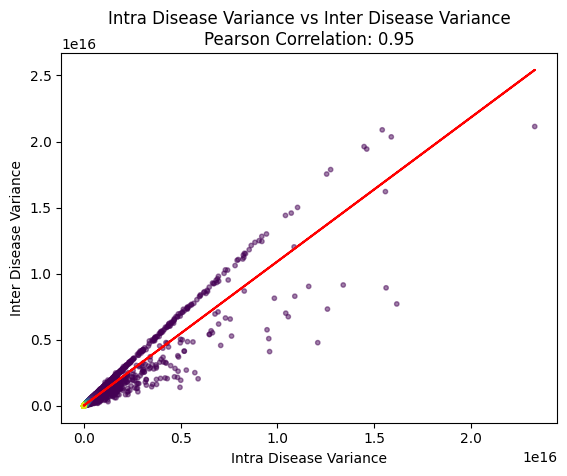

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot Gene Vairance vs Gene Presence


variance_results
variance_results_clean = variance_results.dropna()
y_data = variance_results_clean["inter_disease_var"]
x_data = variance_results_clean["intra_disease_var"]

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Intra Disease Variance")
plt.ylabel("Inter Disease Variance")
plt.title(
    "Intra Disease Variance vs Inter Disease Variance\nPearson Correlation: {:.2f}".format(
        r_value
    )
)

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot Gene Vairance vs Gene Presence


variance_results
variance_results_clean = variance_results.dropna()
y_data = variance_results_clean["inter_disease_var"]
x_data = variance_results_clean["disease_vs_control_var"]

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Intra Disease Variance")
plt.ylabel("Disease-Control Variance")
plt.title(
    "Intra Disease Variance vs Disease-Control Variance\nPearson Correlation: {:.2f}".format(
        r_value
    )
)

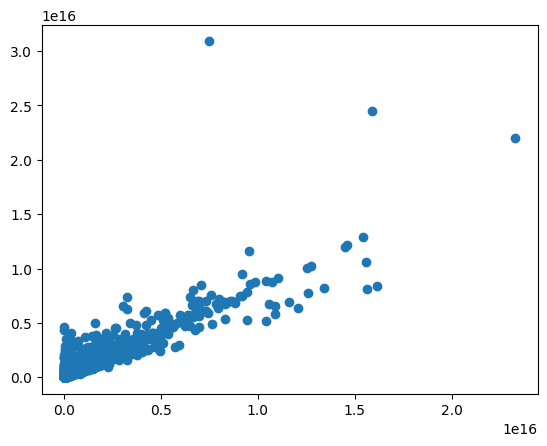

In [95]:
plt.scatter(
    variance_results["intra_disease_var"], variance_results["disease_vs_control_var"]
)

In [87]:
intra_disease_var

,0,1,2,3,4,5,6,7,8,9,...,19680,19681,19682,19683,19684,19685,19686,19687,19688,19689
disease,,,,,,,,,,,,,,,,,,,,,
Breast Cancer,5.585791e+13,1.748949e+15,5.998811e+13,3.748822e+14,2.224808e+14,1.100344e+15,1.851494e+13,1.073753e+14,1.991901e+13,7.585606e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.821119e+15,31.053480
Colorectal Carcinoma,5.867213e+03,1.657429e+06,4.313312e+05,8.715821e+04,1.430623e+06,2.854360e+04,2.828476e+05,6.845682e+02,2.262469e+06,1.052245e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.799846e+02,13.950167
Control,1.090301e+13,8.094029e+13,1.982014e+13,4.605353e+14,4.539059e+14,9.735362e+14,4.423274e+12,1.074259e+13,9.451230e+13,1.577873e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.365157e+14,17.659166
Influenza,1.620445e+03,1.509411e+03,4.242721e+04,1.036061e+02,4.778916e+05,3.346238e+04,1.308737e+05,9.552229e+01,7.980582e+05,2.599565e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.343140e+02,NaN


In [83]:
variance_df[
    (variance_df["intra_disease_var"] > 0.5) & (variance_df["inter_disease_var"] < 0.5)
]

,intra_disease_var,inter_disease_var
1220,588.401774,0.361861
2360,1.186597,0.175902
10069,2.271271,0.108105
12245,0.725632,0.164737
12446,0.782216,0.004759
...,...,...
19451,456.571315,0.355329
19550,6.999935,0.228084
19568,52.036539,0.139211
19581,41.911244,0.121393


In [30]:
adata_bm.shape

(5090, 19690)

In [24]:
adata_bm.obs["celltype"].unique()

['Control', 'Colorectal Carcinoma', 'Breast Cancer', 'Influenza']
Categories (4, object): ['Breast Cancer', 'Colorectal Carcinoma', 'Control', 'Influenza']

In [29]:
adata_nw.shape

(5108, 19690)

In [40]:
from typing import *
import anndata as AnnData


def get_mask_genes(
    adata: AnnData,
    max_n_genes: int = 3501,
    gene_presence_pct: float = 0.95,
) -> np.array:
    """
    Filters genes based on presence and variance, returning a mask of selected genes.

    Parameters:
    - adata: AnnData object containing gene expression data
    - max_n_genes: The maximum number of genes to retain based on variance
    - gene_presence_pctl: Percentile of gene presence for the filtering threshold

    Returns:
    - A boolean array (mask) indicating which genes to keep.
    """
    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    # Step 1: Filter out based on presence
    count_presence = np.sum(~np.isnan(adata.X), axis=0)
    thr_presence = gene_presence_pct * total_n_samples
    mask_presence = count_presence > thr_presence
    logging.info(
        f"Presence threshold: {thr_presence:.0f} ({thr_presence/total_n_genes*100:.2f}%), {np.sum(mask_presence)} genes left"
    )

    # Step 2: Filter out based on variance
    count_variance = np.nanstd(adata.X, axis=0)  # Standard deviation (variance)

    # Step 3: Apply the presence mask and filter out NaN genes
    count_variance_masked = count_variance[mask_presence]
    count_variance_masked = count_variance_masked[~np.isnan(count_variance_masked)]

    # Step 4: Get the variance threshold, ensuring we don’t exceed available genes
    n_variance_masked_genes = len(count_variance_masked)
    thr_variance = np.sort(count_variance_masked)[::-1][
        min(max_n_genes, n_variance_masked_genes) - 1  # Adjust for 0-based indexing
    ]

    # Step 5: Create the variance mask
    mask_variance = count_variance >= thr_variance
    logging.info(
        f"Variance threshold: {thr_variance:.0f}, {np.sum(mask_variance)} genes left"
    )

    # Step 6: Combine presence and variance masks
    combined_mask = mask_presence & mask_variance
    logging.info(f"Combined mask: {np.sum(combined_mask)} genes left")

    return combined_mask

In [31]:
presence = 0.95  # gene presence in samples
variance = 45  # gene variance in top %

# filter out the genes with lowest presence
thr_presence = adata_nw.X.shape[0] * presence

mask_presence = np.sum(~np.isnan(adata_nw.X), axis=0) > thr_presence

logging.info(f"Presence thr {thr_presence}, {np.sum(mask_presence)} genes left")


# filter out the genes with lowest standard deviation
gene_std = np.nanstd(adata_nw.X, axis=0)
gene_std = gene_std[~np.isnan(gene_std)]
thr_std = np.percentile(gene_std, variance)

mask_variance = np.nanstd(adata_nw.X, axis=0) > thr_std


logging.info(f"Variance thr {thr_std:.2f}, {np.sum(mask_variance)} genes left")

# combine mask
mask_genes = mask_presence & mask_variance

2024-09-23 12:39:03,765 - root - INFO - Presence thr 4852.599999999999, 6311 genes left
/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
2024-09-23 12:39:04,787 - root - INFO - Variance thr 7901173.85, 10603 genes left


/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<Axes: ylabel='Density'>

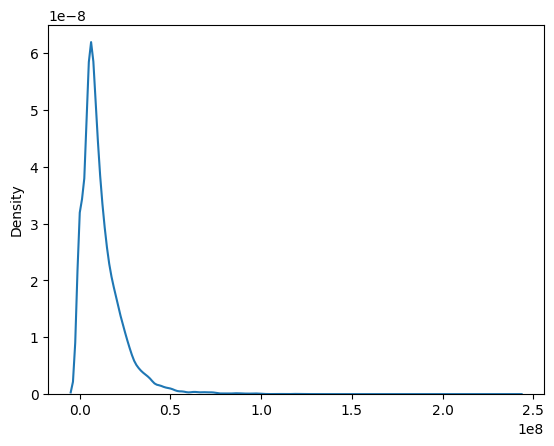

In [21]:
import seaborn as sns

sns.kdeplot(np.nanstd(adata_nw.X, axis=0))

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_12613/3506046679.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Gene Variance Distribution')

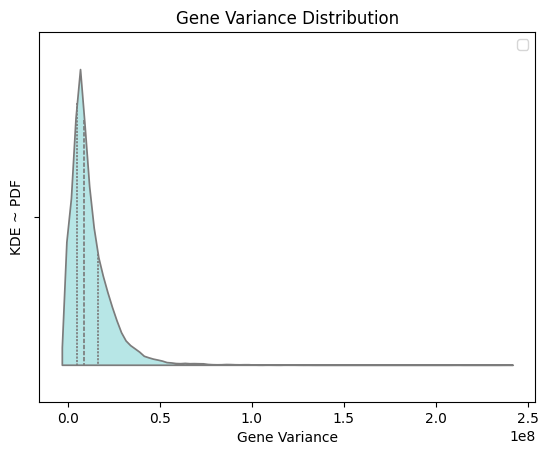

In [67]:
# Plot Gene Variance across samples

import matplotlib.pyplot as plt

presence = 0.95  # gene presence in samples

# filter out the genes with lowest presence
thr_presence = adata_nw.X.shape[0] * presence

data = np.nanstd(adata_nw.X, axis=0)

sns.violinplot(
    data,
    orient="h",
    # inner_kws=dict(box_width=15, whis_width=2, color=".8"),
    split=True,
    inner="quartile",
    color="paleturquoise",
)


plt.ylabel("KDE ~ PDF")
plt.xlabel("Gene Variance")

plt.legend()
plt.title(f"Gene Variance Distribution")

Text(0.5, 1.0, 'Gene Variance vs Gene Presence\nPearson Correlation: 0.07')

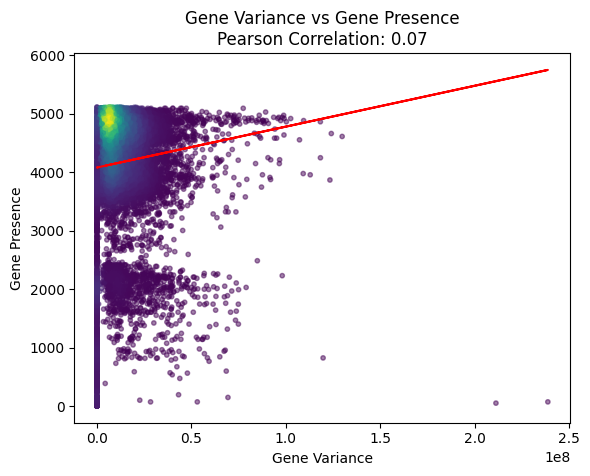

In [65]:
# Plot Gene Vairance vs Gene Presence
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# remove genes w/ no presence
mask_presence = np.sum(~np.isnan(adata_nw.X), axis=0) > 0

x_data = np.nanstd(adata_nw.X[:, mask_presence], axis=0)
y_data = np.sum(~np.isnan(adata_nw.X[:, mask_presence]), axis=0)

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Gene Variance")
plt.ylabel("Gene Presence")
plt.title("Gene Variance vs Gene Presence\nPearson Correlation: {:.2f}".format(r_value))

Text(0.5, 1.0, 'Gene presence (19690) across samples (5108)')

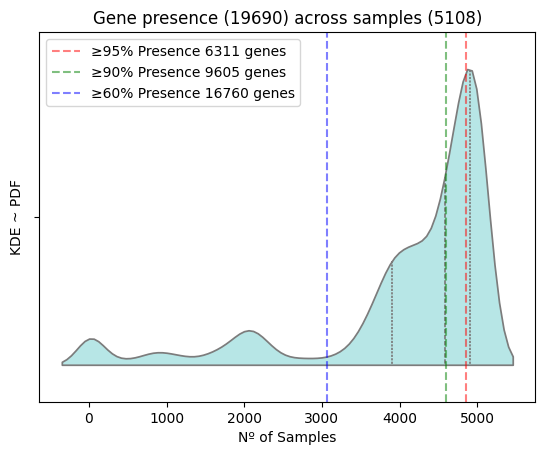

In [42]:
# Plot presence of of gene across samples

import matplotlib.pyplot as plt

presence = 0.95  # gene presence in samples

# filter out the genes with lowest presence
thr_presence = adata_nw.X.shape[0] * presence

data = np.sum(~np.isnan(adata_nw.X), axis=0)

sns.violinplot(
    data,
    orient="h",
    # inner_kws=dict(box_width=15, whis_width=2, color=".8"),
    split=True,
    inner="quartile",
    color="paleturquoise",
)

plt.axvline(
    adata_nw.X.shape[0] * 0.95,
    color="red",
    label=f"≥95% Presence {np.sum(data>=adata_nw.X.shape[0] * 0.95)} genes",
    alpha=0.5,
    linestyle="--",
)
plt.axvline(
    adata_nw.X.shape[0] * 0.9,
    color="green",
    label=f"≥90% Presence {np.sum(data>=adata_nw.X.shape[0] * 0.90)} genes",
    alpha=0.5,
    linestyle="--",
)
plt.axvline(
    adata_nw.X.shape[0] * 0.6,
    color="blue",
    label=f"≥60% Presence {np.sum(data>=adata_nw.X.shape[0] * 0.60)} genes",
    alpha=0.5,
    linestyle="--",
)
plt.ylabel("KDE ~ PDF")
plt.xlabel("Nº of Samples")

plt.legend()
plt.title(f"Gene presence ({adata_nw.shape[1]}) across samples ({adata_nw.shape[0]})")

In [46]:
list_1 = adata_nw.var["gene_symbols"][mask_genes].to_list()

mask_genes_2 = get_mask_genes(adata_nw, gene_presence_pct=0.95)
list_2 = adata_nw.var["gene_symbols"][mask_genes_2].to_list()


print(len(list_1), len(list_2))

print(len(set(list_1) & set(list_2)))

2024-09-23 12:43:50,185 - root - INFO - Presence threshold: 4853 (24.64%), 6311 genes left
2024-09-23 12:43:50,697 - root - INFO - Variance threshold: 7129126, 11519 genes left
2024-09-23 12:43:50,697 - root - INFO - Combined mask: 3501 genes left


3095 3501
3095


In [1]:
import anndata as ad


adata_nw = ad.read_h5ad("/aloy/home/ddalton/projects/scGPT_playground/data/pp_data-24-09-24-01/data.h5ad")

In [9]:
from typing import *
import numpy as np
import pandas as pd
import anndata as AnnData
import logging

logging.basicConfig(level=logging.INFO)


def get_top_k_most_present_genes(
    adata: AnnData,
    k: int = 3501,
) -> np.array:
    """
    Filters genes based on the top `k` most present genes across samples.

    Parameters:
    - adata: AnnData object containing gene expression data
    - k: The number of top genes to retain based on their presence across samples

    Returns:
    - A boolean array (mask) indicating which genes to keep.
    """
    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    logging.info(f"Nº genes: {total_n_genes}, Nº samples: {total_n_samples}")

    # Step 1: Count gene presence (non-NaN values) across samples
    count_presence = np.sum(~np.isnan(adata.X), axis=0)

    # Step 2: Sort genes by presence and select the top `k`
    top_k_indices = np.argsort(count_presence)[::-1][:k]

    # Step 3: Create a boolean mask with `True` for the top `k` genes
    mask_top_k = np.zeros(total_n_genes, dtype=bool)
    mask_top_k[top_k_indices] = True



    logging.info(f"Top {k} most present genes selected. - >= {min(count_presence[mask_top_k])}")

    return mask_top_k



def get_mask_genes(
    adata: AnnData,
    max_n_genes: int = 3501,
    gene_presence_pct: float = 0.95,
) -> np.array:
    """
    Filters genes based on presence and variance, returning a mask of selected genes.

    Parameters:
    - adata: AnnData object containing gene expression data
    - max_n_genes: The maximum number of genes to retain based on variance
    - gene_presence_pctl: Percentile of gene presence for the filtering threshold

    Returns:
    - A boolean array (mask) indicating which genes to keep.
    """
    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    logging.info(f"Nº genes: {total_n_genes}, Nº samples: {total_n_samples}")


    # Step 1: Filter out based on presence
    count_presence = np.sum(~np.isnan(adata.X), axis=0)
    thr_presence = gene_presence_pct * total_n_samples
    mask_presence = count_presence > thr_presence
    logging.info(
        f"Presence threshold: {thr_presence:.0f} ({thr_presence/total_n_genes*100:.2f}%), {np.sum(mask_presence)} genes left"
    )

    # Step 2: Filter out based on variance
    count_variance = np.nanstd(adata.X, axis=0)  # Standard deviation (variance)

    # Step 3: Apply the presence mask and filter out NaN genes
    count_variance_masked = count_variance[mask_presence]
    count_variance_masked = count_variance_masked[~np.isnan(count_variance_masked)]

    # Step 4: Get the variance threshold, ensuring we don’t exceed available genes
    n_variance_masked_genes = len(count_variance_masked)
    thr_variance = np.sort(count_variance_masked)[::-1][
        min(max_n_genes, n_variance_masked_genes) - 1  # Adjust for 0-based indexing
    ]

    # Step 5: Create the variance mask
    mask_variance = count_variance >= thr_variance
    logging.info(
        f"Variance threshold: {thr_variance:.0f}, {np.sum(mask_variance)} genes left"
    )

    # Step 6: Combine presence and variance masks
    combined_mask = mask_presence & mask_variance
    logging.info(f"Combined mask: {np.sum(combined_mask)} genes left")

    return combined_mask

In [17]:
get_mask_genes(adata_nw, gene_presence_pct=0.9999999)

get_top_k_most_present_genes(adata_nw)

INFO:root:Nº genes: 19690, Nº samples: 1231
INFO:root:Presence threshold: 1231 (6.25%), 14597 genes left
INFO:root:Variance threshold: 1061, 3786 genes left
INFO:root:Combined mask: 3501 genes left
INFO:root:Nº genes: 19690, Nº samples: 1231
INFO:root:Top 3501 most present genes selected. - >= 1231


array([ True,  True,  True, ..., False, False, False])

In [13]:
list(np.sum(~np.isnan(adata_nw.X),axis=0)).count(1231)

14597

In [18]:
import anndata as ad

adata_nw = ad.read_h5ad("/aloy/home/ddalton/projects/scGPT_playground/data/pp_data-24-09-24-01/data.h5ad")

In [27]:
for disease in adata_nw.obs["disease_study"].unique():
    QUERY = "disease_study == @disease"
    df_query = adata_nw.obs.query(QUERY)
    print(disease, df_query["dataset_id"].nunique())

Colorectal Carcinoma 11
Breast Cancer 11
Influenza 4


In [30]:
import os,  pandas as pd
df_info_path = os.path.join(
    "/aloy",
    "home",
    "ddalton",
    "projects",
    "disease_signatures",
    "data",
    "DiSignAtlas",
    "Disease_information_Datasets_extended.csv",
)



df_info = pd.read_csv(df_info_path)

In [37]:

diseases_with_multiple_datasets = []

for disease in df_info["disease"].unique():

    QUERY = "disease == @disease"
    df_q = df_info.query(QUERY)
    if df_q[df_q["library_strategy"]=="Microarray"]["accession"].nunique() >= 5:

        if df_q[df_q["library_strategy"]=="RNA-Seq"]["accession"].nunique() >= 5:
            diseases_with_multiple_datasets.append([disease, df_q[df_q["library_strategy"]=="Microarray"]["accession"].nunique(), df_q[df_q["library_strategy"]=="RNA-Seq"]["accession"].nunique()])



diseases_with_multiple_datasets

[["Alzheimer's Disease", 43, 39],
 ['Myotonic Dystrophy Type 1', 7, 6],
 ['Diabetes', 36, 7],
 ['COVID-19', 8, 66],
 ['Diabetic Kidney Disease', 10, 6],
 ['Amyotrophic Lateral Sclerosis', 22, 23],
 ['Colon Cancer', 7, 7],
 ['Lung Cancer', 13, 5],
 ['Prostate Cancer', 21, 9],
 ['Cardiomyopathy', 6, 12],
 ['Leukemia', 8, 9],
 ['Colorectal Carcinoma', 39, 19],
 ['Type 1 Diabetes', 26, 16],
 ['Type 2 Diabetes', 20, 13],
 ['Osteoarthritis', 17, 9],
 ['Asthma', 46, 26],
 ['Atherosclerosis', 10, 5],
 ['Breast Cancer', 51, 14],
 ['Polycystic Ovary Syndrome', 14, 10],
 ['Psoriasis', 37, 16],
 ['Myocardial Infarction', 10, 13],
 ['Pancreatic Cancer', 6, 8],
 ['Dilated Cardiomyopathy', 6, 10],
 ['Obesity', 36, 41],
 ["Parkinson's Disease", 38, 38],
 ['Non-Alcoholic Fatty Liver Disease', 9, 13],
 ['Systemic Lupus Erythematosus', 38, 31],
 ['Melanoma', 25, 14],
 ['Atopic Dermatitis', 16, 6],
 ['Juvenile Idiopathic Arthritis', 10, 7],
 ['Hepatocellular Carcinoma', 55, 20],
 ['Non-Alcoholic Steatohep

In [32]:
df_info.columns

Index(['dsaid', 'accession', 'platform', 'deg_count', 'disease', 'diseaseid',
       'tissue', 'data_source', 'library_strategy', 'organism',
       'control_case_sample_count', 'definition', 'Control', 'Case'],
      dtype='object')

In [38]:
import anndata as ad

adata_nw = ad.read_h5ad("/aloy/home/ddalton/projects/scGPT_playground/data/pp_data-24-09-24-01/data.h5ad")

In [49]:

list(np.sum(~np.isnan(adata_nw.X), axis=0)).count(4561)

12827

In [61]:
def get_top_k_most_present_genes(
    adata: AnnData,
    k: int = 3501,
) -> np.array:
    """
    Filters genes based on the top `k` most present genes across samples.
    If there are more genes with the same presence, the top `k` will be selected
    based on variance as a secondary criterion.

    Parameters:
    - adata: AnnData object containing gene expression data
    - k: The number of top genes to retain based on their presence across samples

    Returns:
    - A boolean array (mask) indicating which genes to keep.
    """
    total_n_genes = adata.X.shape[1]
    total_n_samples = adata.X.shape[0]

    logging.info(f"Nº genes: {total_n_genes}, Nº samples: {total_n_samples}")

    # Step 1: Count gene presence (non-NaN and non-zero values) across samples
    count_presence = np.sum(~np.isnan(adata.X), axis=0)

    # Step 2: Sort genes by presence in descending order
    sorted_indices = np.argsort(count_presence)[::-1]

    # Step 3: Handle the case where multiple genes have the same presence
    top_k_indices = sorted_indices[:k]
    
    if k < len(sorted_indices) and count_presence[top_k_indices[-1]] == count_presence[sorted_indices[k]]:
        min_presence = count_presence[top_k_indices[-1]]

        # Step 4: Find all genes with the same presence as the cutoff
        equal_presence_indices = sorted_indices[count_presence[sorted_indices] == min_presence]

        # Step 5: If the number of equal presence genes exceeds `k`, use variance as a tie-breaker
        remaining_slots = k - np.sum(count_presence[sorted_indices[:k]] > min_presence)
        if len(equal_presence_indices) > remaining_slots:
            # Compute variance for all genes
            gene_variance = np.std(adata.X, axis=0)
            
            # Sort equal presence genes by variance in descending order
            sorted_by_variance = equal_presence_indices[np.argsort(gene_variance[equal_presence_indices])[::-1]]

            # Replace the last entries in the top `k` with highest variance genes from the tie
            top_k_indices = np.concatenate(
                [sorted_indices[count_presence[sorted_indices] > min_presence], 
                 sorted_by_variance[:remaining_slots]]
            )
        else:
            top_k_indices = sorted_indices[:k]

    # Step 6: Create a boolean mask for the top `k` genes
    mask_top_k = np.zeros(total_n_genes, dtype=bool)
    mask_top_k[top_k_indices] = True

    logging.info(f"Top {k} most present genes selected. - >= {min(count_presence[mask_top_k])}")

    return mask_top_k

get_top_k_most_present_genes(adata_nw)

INFO:root:Nº genes: 19690, Nº samples: 4561
INFO:root:Top 3501 most present genes selected. - >= 4561


array([False,  True, False, ..., False, False, False])

In [55]:
np.sum(np.sum(~np.isnan(adata_nw.X), axis=0)>=4561)

12827